






# Time series of diversity of fs and ns, IBM data

Adapted from previous scripts and formatted to correspond to '210825_f_all_sp_simpler_all_rounds.py' by Pablo Guridi Fernandez

In [1]:
import os
import copy
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, isdir, join
from ast import literal_eval
from datetime import date, datetime
from collections import Counter
from scipy.stats import wilcoxon
from scipy.stats import shapiro


In [2]:
#path evolved communities
path = "/Users/pablo/Desktop/code_paper/data/210822/"  
#path_ancestral = "/Users/pablo/Desktop/data_mitri/211119/"


#some information about these results (210822)
num_repeats = 10
num_toxins = 10
num_tubes = 21
rounds = 50
total_sp = 15
rd = 49 #when to take the degradation of evolved communities
#The seeeds we have used for the rng generator and that name the directory to store resutls
seeds = ["22", "23", "24", "25", "26"] #renamed as 1-5 just for the plot
#Propagations to load
prop = "d3_s"
#for the final plots we will give different names than those from the model(here IN THE SAME ORDER!)
prop_rename = "D3S"

Nnutr = 4
Ntox = 10

ns = ["n" + str(x) for x in range(Nnutr)]
fs = ["f" + str(x) for x in range(Ntox)]
ms = ["m" + str(x) for x in range(Ntox)]

open_file = open(path + "dict_combs", "rb")
dict_combs = pickle.load(open_file)
open_file.close()

#path where to store the plots
path_save = "/Users/pablo/Desktop/220628_plots_mitri/"

In [3]:
#### The time-series with alpha diversity of nutrients and toxic compounds
#### Supplementary

#methstr = 'Disassembly'
#trstr = 'Selection'
#titlestr = methstr+', selection'

#### Loop through each selection directory
df_alltsf = pd.DataFrame(columns=('Method','Set','Repeat','Tsf',
                                  'DivN','DivT','covN','covT'),dtype=int)

tsfvec  = range(rounds)
tubevec = range(num_tubes)
for idxseed, seed in enumerate(seeds):
    #### Find 'Allcomms' folder
    pathseed = join(path,seed)
    
    #### Read initial species pool
    open_file = open(pathseed +"/d3_s/Species", "rb")
    species = pickle.load(open_file)
    open_file.close()
    
    #### Growth rates
    arr_ns = np.zeros((total_sp,Nnutr))
    arr_fs_anc = np.zeros((total_sp,Ntox))
    for idxsp,sdict in enumerate(species):
        arr_ns[idxsp] = sdict['ns'][:]
        arr_fs_anc[idxsp] = sdict['fs'][:]
    
    #### Then, find all relevant repeats
    pathsel = join(pathseed,prop)
    replist = np.sort([fn for fn in listdir(pathsel) if isdir(join(pathsel,fn))])
    replist = [d for d in replist if 'repeat' in d] # just in case
    
    #### Construct dataframe for histogram. 
    for idxr, repdir in enumerate(replist): 
        pathrep = join(pathsel,repdir)
        # data = pd.read_csv(join(pathrep,"df_sp.csv")) #for auc
        df_st = pd.read_csv(join(pathrep,"df_st.csv"))
        df_st['st'] = df_st.st.apply(lambda x: literal_eval(str(x)))
        
        ### For every rounds of transfer 
        divShN = np.ones(rounds)
        divShT = np.ones(rounds)
        covN_tsf = np.ones(rounds)
        covT_tsf = np.ones(rounds)
        for itsf,tsf in enumerate(tsfvec):
            # dfsp_tsf = data.loc[data.loc[:,'round']==tsf,:]
            dfst_tsf = df_st.loc[df_st.loc[:,'round']==tsf,:]
            
            arr_divN_tubes = np.ones(num_tubes)
            arr_divT_tubes = np.ones(num_tubes)
            arr_covN_tubes = np.ones(num_tubes)
            arr_covT_tubes = np.ones(num_tubes)
            for idxtb,tb in enumerate(tubevec):
                # dfsp_tube = dfsp_tsf.loc[dfsp_tsf.tube==tb,:]
                dfst_tube = dfst_tsf.loc[dfst_tsf.tube==tb,:]
        
                dfst_nonzero = dfst_tube.loc[dfst_tube.final_pop>0,:]
                if dfst_nonzero.empty:
                    continue
                
                ### Find the species composition for this tube
                composition = np.unique(dfst_nonzero.sp)
        
                ### Diversity of investments in the community is the average/sum
                ##  of the investments of each species. We will add all species
                ##  contributions in the same vectors 'toxvec' and 'nutrvec'
                toxvec  = np.zeros(Ntox)
                nutrvec = np.zeros(Nnutr)
                for sp in composition:
                    dfst_spec = dfst_nonzero.loc[dfst_nonzero.sp==sp,:]
                    
                    #### Find strains, if any
                    if type(dfst_spec) is pd.DataFrame:
                        Nstr = len(dfst_spec)
                        toxmat = np.ones((Nstr,Ntox))
                        popsizes = dfst_spec.final_pop.values
                        for idxstr,val in enumerate(dfst_spec.st):
                            toxmat[idxstr,:] = list(val)
                            
                        toxvec_scaled = np.dot(popsizes,toxmat)
                        toxvec += np.divide(toxvec_scaled, np.sum(popsizes))
                    elif type(dfst_spec) is pd.Series: # Else: nothing?
                        toxvec += list(dfst_spec.st)

                    ### Nutrient uptake
                    nutrvec += arr_ns[sp]
                    
                #### Coverage, without considering diversity
                arr_covT_tubes[idxtb] = np.sum(toxvec>0)
                arr_covN_tubes[idxtb] = np.sum(nutrvec>0)
                
                #### Diversity from relative abundances
                nutrvec_rel  = np.divide(nutrvec, np.sum(nutrvec))
                nutrvec_nonz = nutrvec_rel[nutrvec_rel>0]
                toxvec_rel  = np.divide(toxvec, np.sum(toxvec))
                toxvec_nonz = toxvec_rel[toxvec_rel>0]
        
                arr_divN_tubes[idxtb] = np.exp(-1.0*np.dot(nutrvec_nonz, np.log(nutrvec_nonz)))
                arr_divT_tubes[idxtb] = np.exp(-1.0*np.dot(toxvec_nonz, np.log(toxvec_nonz)))
                
            divShN[itsf] = np.mean(arr_divN_tubes)
            divShT[itsf] = np.mean(arr_divT_tubes)
            
            covN_tsf[itsf] = np.mean(arr_covN_tubes)
            covT_tsf[itsf] = np.mean(arr_covT_tubes)
                
        dftmp = pd.DataFrame({'Method':prop_rename,'Set':idxseed,
                              'Repeat':idxr,'Tsf':tsfvec,
                              'DivN':divShN,'DivT':divShT,
                              'covN':covN_tsf,'covT':covT_tsf})
        df_alltsf = df_alltsf.append(dftmp,ignore_index=True)

print(df_alltsf.head())
 

  Method  Set  Repeat  Tsf      DivN      DivT      covN      covT
0    D3S    0       0    0  3.221112  7.194126  3.809524  9.428571
1    D3S    0       0    1  3.473003  7.382048  3.952381  9.523810
2    D3S    0       0    2  3.624994  7.890720  4.000000  9.952381
3    D3S    0       0    3  3.590951  7.732202  3.904762  9.809524
4    D3S    0       0    4  3.605256  7.698635  3.952381  9.571429


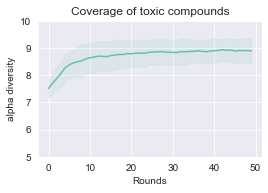

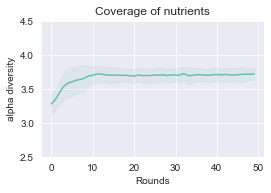

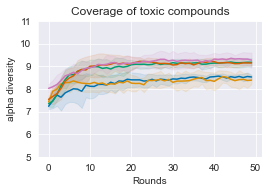

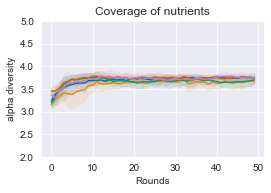

In [4]:
#### Plot single mean
plt.rcParams['svg.fonttype'] = "none"
colours = sns.color_palette("Set2")
cols_perset = sns.color_palette("colorblind")
sns.set_style("darkgrid")
datestr = datetime.today().strftime("%Y%m%d")

fig_DivT_mean, ax_DivT_mean = plt.subplots(nrows=1,ncols=1,sharex='col',sharey='row',figsize=(4,2.5))
fig_DivN_mean, ax_DivN_mean = plt.subplots(nrows=1,ncols=1,sharex='col',sharey='row',figsize=(4,2.5))
fig_DivT_byset, ax_DivT_byset = plt.subplots(nrows=1,ncols=1,sharex='col',sharey='row',figsize=(4,2.5))
fig_DivN_byset, ax_DivN_byset = plt.subplots(nrows=1,ncols=1,sharex='col',sharey='row',figsize=(4,2.5))

#### Find overall mean to plot in single panel    
df_meantot = df_alltsf.groupby(['Method','Set','Tsf']).mean().reset_index()
df_sd_tot  = df_alltsf.groupby(['Method','Set','Tsf']).std().reset_index()
df_meantot.loc[:,'dev_DivN'] = df_sd_tot.DivN
df_meantot.loc[:,'dev_DivT'] = df_sd_tot.DivT

methstr = 'Disassembly'
titlestr = methstr+', selection'
        
#### Plot all in single plot, only means
# df_method_onlymean = df_meantot.loc[df_meantot.Method==prop_rename,:]
for i,s in enumerate(np.unique(df_meantot.Set)):
    coltmp = cols_perset[i]
    dfset_plot = df_meantot.loc[df_meantot.Set==s,:]
    dfset_plot.plot(x='Tsf',y='DivN',ls='-',color=coltmp,ax=ax_DivN_byset,legend=False)
    ax_DivN_byset.fill_between(x=dfset_plot.Tsf, 
                              y1=np.subtract(dfset_plot.DivN, dfset_plot.dev_DivN), 
                              y2=np.add(dfset_plot.DivN, dfset_plot.dev_DivN), 
                              alpha=0.1, edgecolor='none', color = coltmp)
    dfset_plot.plot(x='Tsf',y='DivT',ls='-',color=coltmp,ax=ax_DivT_byset,legend=False)
    ax_DivT_byset.fill_between(x=dfset_plot.Tsf, 
                              y1=np.subtract(dfset_plot.DivT, dfset_plot.dev_DivT), 
                              y2=np.add(dfset_plot.DivT, dfset_plot.dev_DivT), 
                              alpha=0.1, edgecolor='none', color = coltmp)

#### Set axis labels
ax_DivN_byset.set(xlabel='Rounds',ylabel='alpha diversity',title='Coverage of nutrients')
ax_DivN_byset.set_ylim([2.0,5.0])
ax_DivT_byset.set(xlabel='Rounds',ylabel='alpha diversity',title='Coverage of toxic compounds')
ax_DivT_byset.set_ylim([5,11])
    
#### Find overall mean to plot in single panel    
df_meantot = df_alltsf.groupby(['Method','Tsf']).mean().reset_index()
df_sd_tot  = df_alltsf.groupby(['Method','Tsf']).std().reset_index()
df_meantot.loc[:,'dev_DivN'] = df_sd_tot.DivN
df_meantot.loc[:,'dev_DivT'] = df_sd_tot.DivT
    
#### Plot total average in single frame
df_meantot.plot(x='Tsf',y='DivN',ls='-',color=colours[0],ax=ax_DivN_mean,legend=False)
ax_DivN_mean.fill_between(x=df_meantot.Tsf, 
                              y1=np.subtract(df_meantot.DivN, df_meantot.dev_DivN), 
                              y2=np.add(df_meantot.DivN, df_meantot.dev_DivN), 
                              alpha=0.1, edgecolor='none', color = colours[0])
df_meantot.plot(x='Tsf',y='DivT',ls='-',color=colours[0],ax=ax_DivT_mean,legend=False)
ax_DivT_mean.fill_between(x=df_meantot.Tsf, 
                              y1=np.subtract(df_meantot.DivT, df_meantot.dev_DivT), 
                              y2=np.add(df_meantot.DivT, df_meantot.dev_DivT), 
                              alpha=0.1, edgecolor='none', color = colours[0])

#### Set axis labels
ax_DivN_mean.set(xlabel='Rounds',ylabel='alpha diversity',title='Coverage of nutrients')
ax_DivN_mean.set_ylim([2.5,4.5])
ax_DivT_mean.set(xlabel='Rounds',ylabel='alpha diversity',title='Coverage of toxic compounds')
ax_DivT_mean.set_ylim([5,10])

outfn_DivN_average = path_save + 'Lines_avDivN_IBM_onlyDS_'+str(rounds)+'tsf_'+datestr
outfn_DivT_average = path_save +'Lines_avDivT_IBM_onlyDS_'+str(rounds)+'tsf_'+datestr
outfn_DivN_byset = path_save +'Lines_avDivN_IBM_onlyDS_bySet_'+str(rounds)+'tsf_'+datestr
outfn_DivT_byset = path_save +'Lines_avDivT_IBM_onlyDS_bySet_'+str(rounds)+'tsf_'+datestr

for ftype in ('pdf','svg'):
    #fig_DivT_mean.savefig(outfn_DivT_average+'.'+ftype,format=ftype,bbox_inches='tight')
    #fig_DivN_mean.savefig(outfn_DivN_average+'.'+ftype,format=ftype,bbox_inches='tight')
    fig_DivT_byset.savefig(outfn_DivT_byset+'.'+ftype,format=ftype,bbox_inches='tight')
    fig_DivN_byset.savefig(outfn_DivN_byset+'.'+ftype,format=ftype,bbox_inches='tight')


plt.show()

()

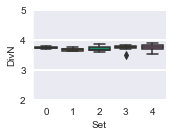

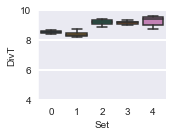

In [5]:
def my_boxplot_norepeats(dfplot, path, fname, argslabels, x='Method', y='Max'):
    # make boxplot
    sns.set_style("darkgrid")
    sns.set_context( rc={"grid.linewidth": 2} )
    fig=plt.figure(figsize=(2.5, 2))
    plt.axhline(y=0, color='black', linestyle='dotted', alpha = 0.5, lw=2, zorder=1) 
    
    bp= sns.boxplot(x=x,y=y, 
                    data=dfplot, 
                    palette="colorblind", 
                    boxprops={"zorder":1},
                    whiskerprops={"zorder":10}) #zorder does not work here though
    
    # get legend information from the plot object
    handles, labels = bp.get_legend_handles_labels()
    ylims = argslabels['ylims']
    plt.ylim(ylims[0], ylims[1])
    # specify just one legend
    # plt.legend(handles[0:5], labels[0:5], title="Species set", fontsize=14, ncol=3, loc="lower left", framealpha=0.5)
    #plt.xticks(fontsize = 18)
    #plt.yticks(fontsize = 18)
    # plt.title(argslabels['Title'], fontsize = 18)
    #plt.ylabel(argslabels['y'], fontsize = 18)
    #plt.xlabel(argslabels['x'], fontsize = 18)
    plt.tight_layout()
    plt.savefig(join(path,fname+".svg"))
    plt.savefig(join(path,fname+".pdf"))
    
    return()

#### Plot boxplot of all repeats
lasttsf = np.unique(df_alltsf.Tsf)[-1]
df_tsf  = df_alltsf.loc[df_alltsf.Tsf==lasttsf,:]

### Plot, save nutrient diversity
outfname_divN = 'Boxplot_nutrient_diversity_IBM_onlyDS_'+datestr
labels_divN   = {'Title':'Nutr diversity per PCs',
                 'y':'Alpha div','x':'Set',
                 'ylims': [2.0,5.0]}
my_boxplot_norepeats(df_tsf, path_save , outfname_divN, labels_divN, x='Set', y='DivN')

### Plot, save nutrient diversity
outfname_divT = 'Boxplot_toxic_diversity_IBM_onlyDS_'+datestr
labels_divT   = {'Title':'Tox diversity per PCs',
                 'y':'Alpha div','x':'Set',
                 'ylims': [4.0,10.0]}
my_boxplot_norepeats(df_tsf, path_save , outfname_divT, labels_divT, x='Set', y='DivT')


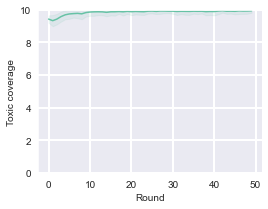

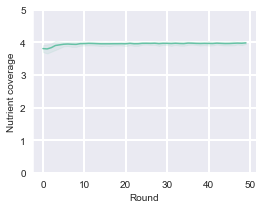

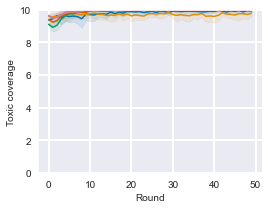

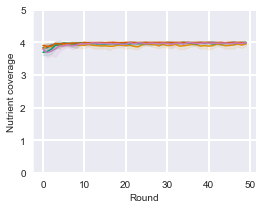

In [6]:
#### Plot single mean
colours = sns.color_palette("Set2")
cols_perset = sns.color_palette("colorblind")
sns.set_style("darkgrid")
datestr = datetime.today().strftime("%Y%m%d")

fig_covT_mean, ax_covT_mean = plt.subplots(nrows=1,ncols=1,sharex='col',sharey='row',figsize=(4,3))
fig_covN_mean, ax_covN_mean = plt.subplots(nrows=1,ncols=1,sharex='col',sharey='row',figsize=(4,3))
fig_covT_byset, ax_covT_byset = plt.subplots(nrows=1,ncols=1,sharex='col',sharey='row',figsize=(4,3))
fig_covN_byset, ax_covN_byset = plt.subplots(nrows=1,ncols=1,sharex='col',sharey='row',figsize=(4,3))

#### Find overall mean to plot in single panel    
df_meantot = df_alltsf.groupby(['Method','Set','Tsf']).mean().reset_index()
df_sd_tot  = df_alltsf.groupby(['Method','Set','Tsf']).std().reset_index()
df_meantot.loc[:,'dev_covN'] = df_sd_tot.covN
df_meantot.loc[:,'dev_covT'] = df_sd_tot.covT

methstr = 'Disassembly'
titlestr = methstr+', selection'
        
#### Plot all in single plot, only means
for i,s in enumerate(np.unique(df_meantot.Set)):
    coltmp = cols_perset[i]
    dfset_plot = df_meantot.loc[df_meantot.Set==s,:]
    dfset_plot.plot(x='Tsf',y='covN',ls='-',color=coltmp,ax=ax_covN_byset,legend=False)
    ax_covN_byset.fill_between(x=dfset_plot.Tsf, 
                              y1=np.subtract(dfset_plot.covN, dfset_plot.dev_covN), 
                              y2=np.add(dfset_plot.covN, dfset_plot.dev_covN), 
                              alpha=0.1, edgecolor='none', color = coltmp)
    dfset_plot.plot(x='Tsf',y='covT',ls='-',color=coltmp,ax=ax_covT_byset,legend=False)
    ax_covT_byset.fill_between(x=dfset_plot.Tsf, 
                              y1=np.subtract(dfset_plot.covT, dfset_plot.dev_covT), 
                              y2=np.add(dfset_plot.covT, dfset_plot.dev_covT), 
                              alpha=0.1, edgecolor='none', color = coltmp)

#### Set axis labels
ax_covN_byset.set(xlabel='Round',ylabel='Nutrient coverage')
ax_covN_byset.set_ylim([0,5])
ax_covT_byset.set(xlabel='Round',ylabel='Toxic coverage')
ax_covT_byset.set_ylim([0,10])
    
#### Find overall mean to plot in single panel    
df_meantot = df_alltsf.groupby(['Method','Tsf']).mean().reset_index()
df_sd_tot  = df_alltsf.groupby(['Method','Tsf']).std().reset_index()
df_meantot.loc[:,'dev_covN'] = df_sd_tot.covN
df_meantot.loc[:,'dev_covT'] = df_sd_tot.covT
    
#### Plot total average in single frame
df_meantot.plot(x='Tsf',y='covN',ls='-',color=colours[0],ax=ax_covN_mean,legend=False)
ax_covN_mean.fill_between(x=df_meantot.Tsf, 
                              y1=np.subtract(df_meantot.covN, df_meantot.dev_covN), 
                              y2=np.add(df_meantot.covN, df_meantot.dev_covN), 
                              alpha=0.1, edgecolor='none', color = colours[0])
df_meantot.plot(x='Tsf',y='covT',ls='-',color=colours[0],ax=ax_covT_mean,legend=False)
ax_covT_mean.fill_between(x=df_meantot.Tsf, 
                              y1=np.subtract(df_meantot.covT, df_meantot.dev_covT), 
                              y2=np.add(df_meantot.covT, df_meantot.dev_covT), 
                              alpha=0.1, edgecolor='none', color = colours[0])

#### Set axis labels
ax_covN_mean.set(xlabel='Round',ylabel='Nutrient coverage')
ax_covN_mean.set_ylim([0,5])
ax_covT_mean.set(xlabel='Round',ylabel='Toxic coverage')
ax_covT_mean.set_ylim([0,10])

outfn_covN_average = path_save + 'Lines_avCoverageN_IBM_onlyDS_'+str(rounds)+'tsf_'+datestr
outfn_covT_average = path_save + 'Lines_avCoverageT_IBM_onlyDS_'+str(rounds)+'tsf_'+datestr
outfn_covN_byset = path_save + 'Lines_avCoverageN_IBM_onlyDS_bySet_'+str(rounds)+'tsf_'+datestr
outfn_covT_byset = path_save + 'Lines_avCoverageT_IBM_onlyDS_bySet_'+str(rounds)+'tsf_'+datestr

for ftype in ('pdf','svg'):
    fig_covT_mean.savefig(outfn_covT_average+'.'+ftype,format=ftype,bbox_inches='tight')
    fig_covN_mean.savefig(outfn_covN_average+'.'+ftype,format=ftype,bbox_inches='tight')
    fig_covT_byset.savefig(outfn_covT_byset+'.'+ftype,format=ftype,bbox_inches='tight')
    fig_covN_byset.savefig(outfn_covN_byset+'.'+ftype,format=ftype,bbox_inches='tight')


plt.show()

In [7]:
#COMPARE ANCESTRAL AND EVOLVED UNDER SELECTION
df_sw = pd.DataFrame( columns = ["Prop", "Quantity", "sw", "p_val"] )

df_degr = df_degauc.loc[:, 'deg_diff']
df_auc  = df_degauc.loc[:, 'auc_diff']

swdeg, pdeg = wilcoxon(df_degr)
swauc, pauc = wilcoxon(df_auc)

Nseeds = len(seeds)
arr_f0 = np.zeros(total_sp*Nseeds)
arr_flast = np.zeros(total_sp*Nseeds)
for idxs,s in enumerate(seeds):
    idx1 = idxs*total_sp
    idx2 = (idxs+1)*total_sp
    arr_f0[idx1:idx2] = f_0[s][:]
    arr_flast[idx1:idx2] = f_last[s][:]
swf, pf = wilcoxon(arr_f0,arr_flast)

df_sw = pd.DataFrame({"Prop":[prop,prop,prop],"Quantity":['Degr','AUC','sumf'],
                      "sw":[swdeg,swauc,swf], "p_val":[pdeg,pauc,pf]})
df_sw.to_csv(path_save + "dfsw_degr_auc_ancVSevol.csv")

NameError: name 'df_degauc' is not defined